**Group Members :**

**Suren Tamang**

**Riya Prajapati**

**Niraj Chaudhary**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

2025-05-08 16:49:00.355295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746722940.630976      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746722940.708567      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Part A: Implementing Convolutional Neural Network from scratch

In [4]:
# Loading dataset path
data_dir = "/kaggle/input/gtsrb-german-traffic-sign"
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))
test_csv = pd.read_csv(os.path.join(data_dir, "Test.csv"))
print(" Train Dataset Loaded!", train_csv.shape)
print(" test Dataset Loaded!", test_csv.shape)

 Train Dataset Loaded! (39209, 8)
 test Dataset Loaded! (12630, 8)


In [5]:
train_csv

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


## Data Understanding, Analysis, Visualization and Cleaning

**Short Description about Dataset**

The GTSRB dataset consists of images of traffic signs from Germany, collected for the purpose of developing and evaluating machine learning models for traffic sign recognition. It contains labeled images of 43 different classes of traffic signs, such as speed limits, warning signs, and regulatory signs. The dataset is used for training and testing models to automatically recognize and classify traffic signs, an essential task for autonomous driving systems and traffic monitoring.

**Total images and classes**

In [6]:
# total number of images
total_images = len(train_csv) + len(test_csv)
print("Total number of images in the dataset:", total_images)

# total classes
unique_class_ids = train_csv['ClassId'].unique()
print("Unique ClassIds:", unique_class_ids)
print("Total Unique ClassIds:", len(unique_class_ids))

Total number of images in the dataset: 51839
Unique ClassIds: [20  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Total Unique ClassIds: 43


**Distribution of images across different classes**

In [7]:
# the distribution of images across different classes in the training set
class_distribution = train_csv['ClassId'].value_counts()

# It prints the distribution
print("Class distribution in the training set:")
print(class_distribution)

Class distribution in the training set:
ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: count, dtype: int64


**Visualizing all the different Signs - Using Train folder**

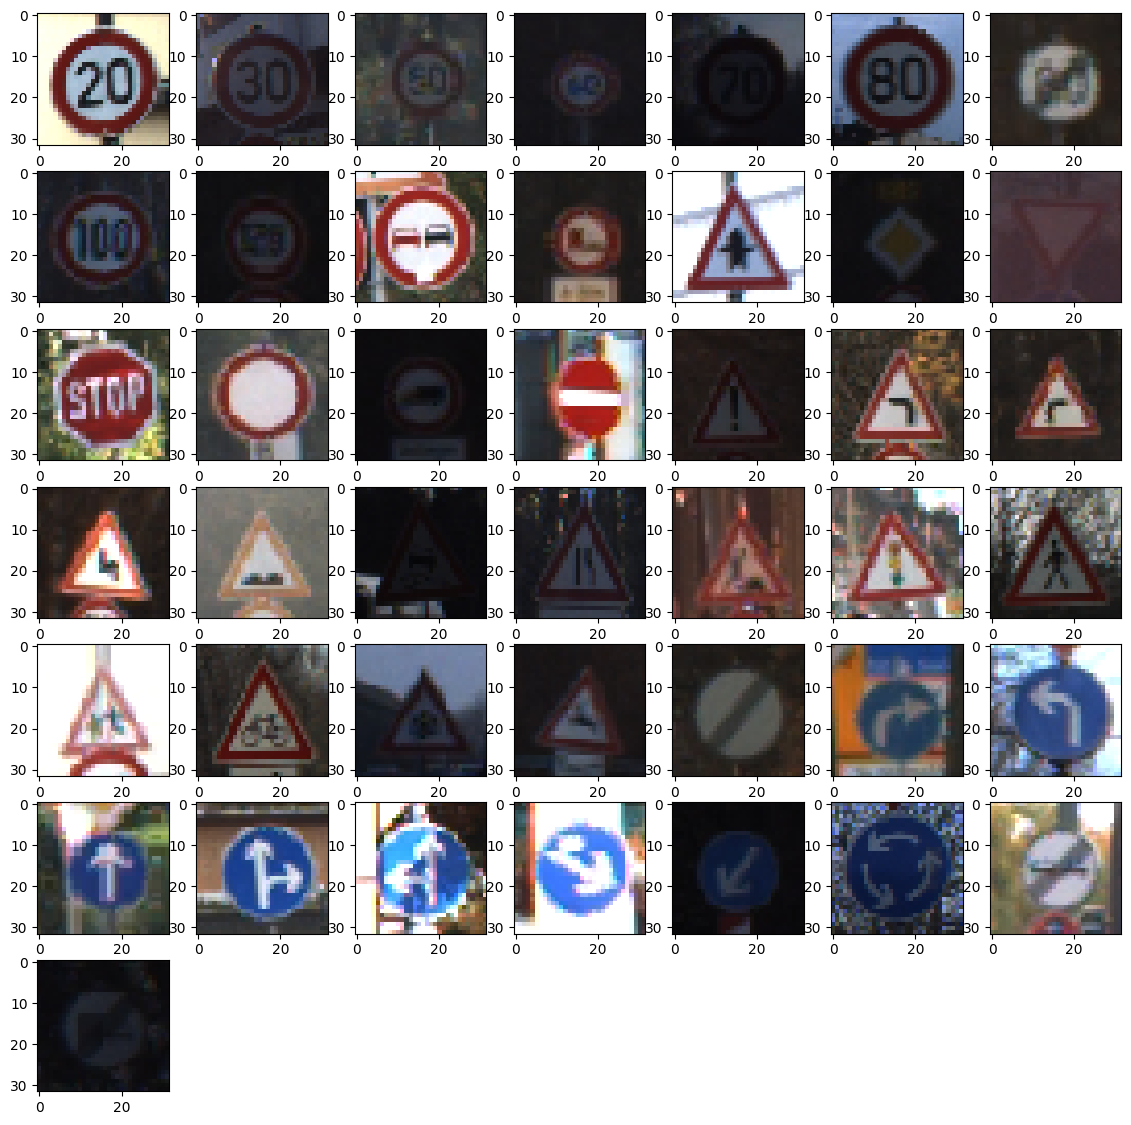

In [8]:
# Visualizing all the different Signs
NUM_CATEGORIES = 43  # Number of classes
IMG_WIDTH, IMG_HEIGHT = 32, 32
train_path = os.path.join(data_dir, "Train")
img_dir = pathlib.Path(train_path)
plt.figure(figsize=(14, 14))
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
plt.show()

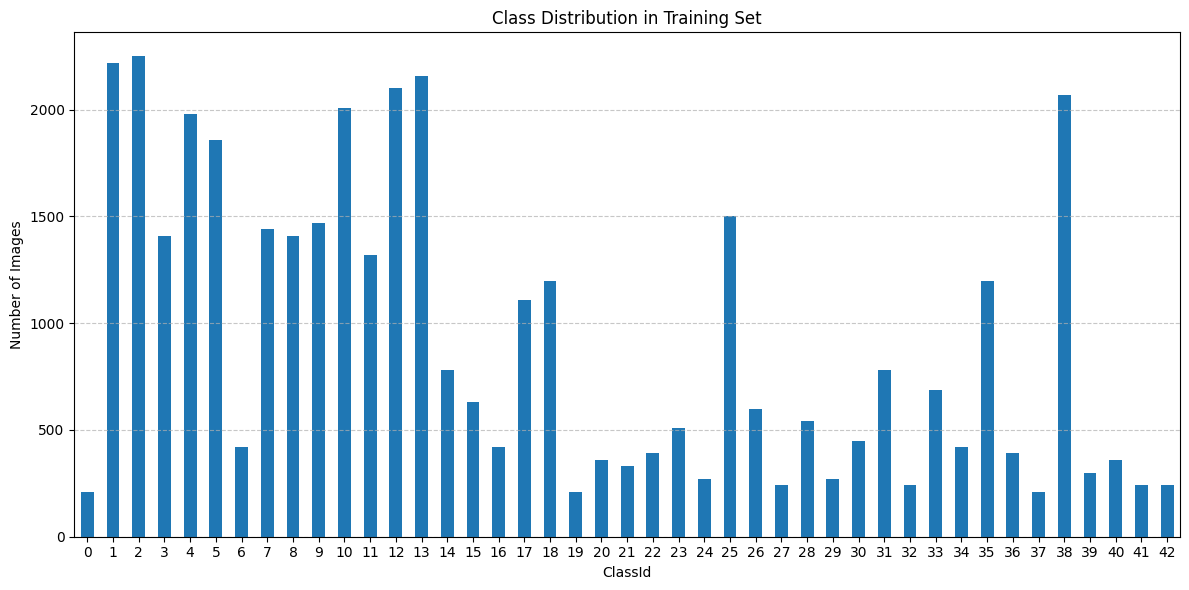

In [9]:
import matplotlib.pyplot as plt

# Count the number of images per class
class_counts = train_csv['ClassId'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution in Training Set")
plt.xlabel("ClassId")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Removing the classes that has less than 500 images.**

In [8]:
# List of ClassIds with fewer than 500 images
classes_to_drop = [30, 16, 6, 34, 22, 36, 40, 20, 21, 39, 29, 24, 32, 27, 41, 42, 37, 0, 19]

# Drop these classes from the dataset, keeps only the rows where 'ClassId' is not in the list
filtered_train_csv = train_csv[~train_csv['ClassId'].isin(classes_to_drop)]  

print("Filtered dataset size:", len(filtered_train_csv))


Filtered dataset size: 33239


In [9]:
# Check the distribution of ClassId after filtering
class_counts_after_filtering = filtered_train_csv['ClassId'].value_counts()

# Print the class distribution
print("Class distribution after filtering:")
print(class_counts_after_filtering)

Class distribution after filtering:
ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
35    1200
18    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
Name: count, dtype: int64


In [10]:
filtered_train_csv

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
570,56,57,6,5,51,52,1,Train/1/00001_00000_00000.png
571,55,57,5,6,50,52,1,Train/1/00001_00000_00001.png
572,56,56,5,6,51,51,1,Train/1/00001_00000_00002.png
573,58,58,6,6,53,52,1,Train/1/00001_00000_00003.png
574,59,59,6,6,54,53,1,Train/1/00001_00000_00004.png
...,...,...,...,...,...,...,...,...
38064,72,72,7,7,66,66,38,Train/38/00038_00068_00025.png
38065,81,82,7,8,74,75,38,Train/38/00038_00068_00026.png
38066,87,93,7,9,80,85,38,Train/38/00038_00068_00027.png
38067,107,107,9,9,98,98,38,Train/38/00038_00068_00028.png


In [11]:
# total number of images
total_images = len(filtered_train_csv)
print("Total number of images in the dataset:", total_images)

# total classes
unique_class_ids = filtered_train_csv['ClassId'].unique()
print("Unique ClassIds:", unique_class_ids)
print("Total Unique ClassIds:", len(unique_class_ids))

Total number of images in the dataset: 33239
Unique ClassIds: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 17 18 23 25 26 28 31 33 35 38]
Total Unique ClassIds: 24


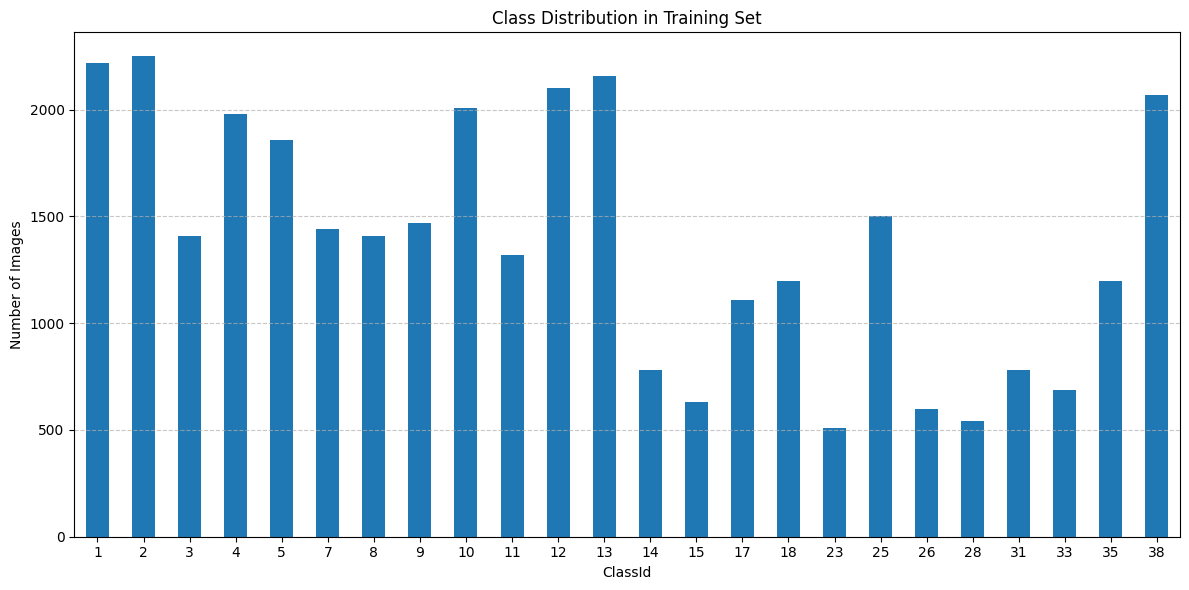

In [14]:
import matplotlib.pyplot as plt

# Count the number of images per class
class_counts = filtered_train_csv['ClassId'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution in Training Set")
plt.xlabel("ClassId")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Checking the size of random image from the dataset**

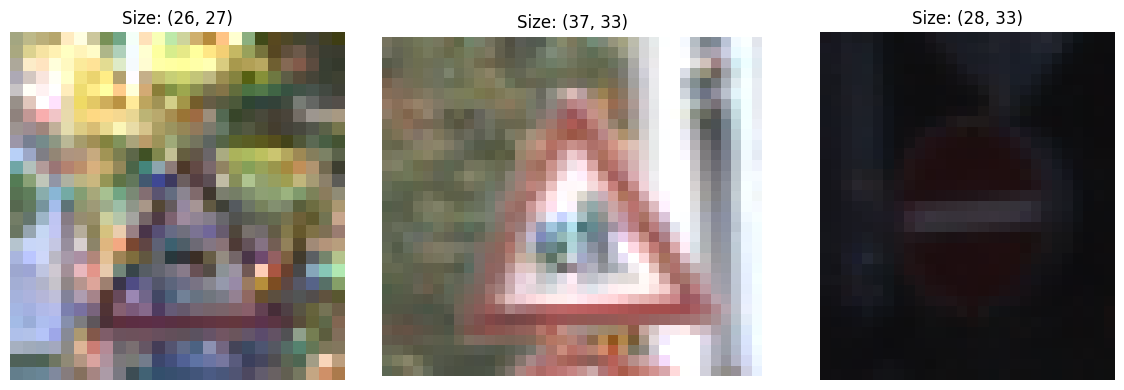

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# List of image paths
image_paths = [
    "/kaggle/input/gtsrb-german-traffic-sign/Train/23/00023_00000_00001.png",
    "/kaggle/input/gtsrb-german-traffic-sign/Train/28/00028_00000_00000.png",
    "/kaggle/input/gtsrb-german-traffic-sign/Train/17/00017_00000_00001.png"
]

# Plot images with sizes
plt.figure(figsize=(12, 4))

for i, path in enumerate(image_paths):
    image = Image.open(path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Size: {image.size}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Checking the corrupted images from Train folder.**

In [8]:
import cv2
import os

# Define the base directory where the images are stored
base_dir = "/kaggle/input/gtsrb-german-traffic-sign/Train"  # Change this if needed

corrupted_images = []

# Iterate through each class folder
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):  # Only process directories
        for img_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, img_filename)
            # Try reading the image with OpenCV
            img = cv2.imread(image_path)
            if img is None:
                print(f"Corrupted or unreadable image: {image_path}")
                corrupted_images.append(image_path)

print(f"\nTotal corrupted images found: {len(corrupted_images)}")


Total corrupted images found: 0


**Preprocessing**

*Resizing*

In [9]:
# Prepare images and labels

X, y = [], []
for i, row in filtered_train_csv.iterrows():
    img_path = os.path.join(data_dir, row['Path'])
    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32))  # Resize to 32x32
    X.append(image)
    y.append(row['ClassId'])

**Normalization - min-max normalization** 

In [10]:
X = np.array(X) / 255.0  # Normalize images
X.shape         # shape is only possible after converting into the numpy array. 

(33239, 32, 32, 3)

In [11]:
import numpy as np

# Convert y to a NumPy array if not already
y = np.array(y)

# Get the number of unique classes
num_classes = len(np.unique(y))

print("Number of unique classes:", num_classes)

Number of unique classes: 24


**Checking the samples for all the classes of filtered dataset**

In [12]:
import numpy as np

# Get the unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print class count
for class_id, count in zip(unique_classes, class_counts):
    print(f"Class {class_id}: {count} samples")


Class 1: 2220 samples
Class 2: 2250 samples
Class 3: 1410 samples
Class 4: 1980 samples
Class 5: 1860 samples
Class 7: 1440 samples
Class 8: 1410 samples
Class 9: 1470 samples
Class 10: 2010 samples
Class 11: 1320 samples
Class 12: 2100 samples
Class 13: 2160 samples
Class 14: 780 samples
Class 15: 630 samples
Class 17: 1110 samples
Class 18: 1200 samples
Class 23: 510 samples
Class 25: 1500 samples
Class 26: 600 samples
Class 28: 540 samples
Class 31: 780 samples
Class 33: 689 samples
Class 35: 1200 samples
Class 38: 2070 samples


**Label encoding  y** - Label encoding will not affec the path of images. This is done for proper run of one hot encoding.

In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels (y)
y = label_encoder.fit_transform(y)

# Check the unique encoded labels
print("Encoded labels:", np.unique(y))

Encoded labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


**Ensuring the number of samples for each classes after label encoding**

In [14]:
import numpy as np

# Get the unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print class count
for class_id, count in zip(unique_classes, class_counts):
    print(f"Class {class_id}: {count} samples")

Class 0: 2220 samples
Class 1: 2250 samples
Class 2: 1410 samples
Class 3: 1980 samples
Class 4: 1860 samples
Class 5: 1440 samples
Class 6: 1410 samples
Class 7: 1470 samples
Class 8: 2010 samples
Class 9: 1320 samples
Class 10: 2100 samples
Class 11: 2160 samples
Class 12: 780 samples
Class 13: 630 samples
Class 14: 1110 samples
Class 15: 1200 samples
Class 16: 510 samples
Class 17: 1500 samples
Class 18: 600 samples
Class 19: 540 samples
Class 20: 780 samples
Class 21: 689 samples
Class 22: 1200 samples
Class 23: 2070 samples


**One-hot encoding the class labels**

In [13]:
# Now you can apply one-hot encoding
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

# Check the shape of the one-hot encoded labels
print("One-hot encoded y shape:", y.shape)

One-hot encoded y shape: (33239, 24)


**Split into training and validation sets**

In [14]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data Split Done! Train Shape:", X_train.shape, "Val Shape:", X_val.shape)

Data Split Done! Train Shape: (26591, 32, 32, 3) Val Shape: (6648, 32, 32, 3)


In [15]:
# small training set
X_train_small = X_train[:2660]
y_train_small = y_train[:2660]

**Data Augmentation - ImageDataGenerator**

In [26]:
# # Data Augmentation
# datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.15, width_shift_range=0.1, height_shift_range=0.1)

In [27]:
# datagen

##  Design, Train, and Evaluate a Baseline Model

### Model Architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    # 1st Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),

    # 2nd Convolutional Layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    # 3rd Convolutional Layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    # Flattening the 3D output to 1D
    Flatten(),

    # Fully Connected Layers (FCNs)
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    # Output Layer for 43 classes (softmax for multi-class classification)
    Dense(24, activation='softmax')  # Adjust this to match the number of classes (43 in your case)
])


2025-05-01 07:43:23.939401: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 24)                  │           1,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 660,504 (2.52 MB)

 Trainable params: 660,504 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #default learning rate is 0.001 for Adam

### Model Training

In [31]:
# # Training Model
# history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=15)

In [32]:
import time

start_time = time.time()

history = model.fit(X_train_small, y_train_small, validation_data=(X_val, y_val), batch_size=32, epochs=30)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.0849 - loss: 3.1047 - val_accuracy: 0.1688 - val_loss: 2.7602
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.2390 - loss: 2.4584 - val_accuracy: 0.3887 - val_loss: 1.8105
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4509 - loss: 1.6300 - val_accuracy: 0.5340 - val_loss: 1.3124
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5636 - loss: 1.1933 - val_accuracy: 0.6360 - val_loss: 1.0569
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.6345 - loss: 0.9960 - val_accuracy: 0.6707 - val_loss: 0.9122
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7091 - loss: 0.7987 - val_accuracy: 0.7401 - val_loss: 0.7180
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8150 - loss: 0.4961 - val_accuracy: 0.8302 - val_loss: 0.5388
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9054 - loss: 0.2953 - val_accuracy: 0.8052 - 

In [33]:
# assuming you’ve already done:
train_accuracies = history.history['accuracy']
val_accuracies   = history.history['val_accuracy']

# final training accuracy
print(f"Final training accuracy:   {train_accuracies[-1]*100:.2f}%")

# final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")


Final training accuracy:   100.00%
Final validation accuracy: 94.27%


Text(0.5, 1.0, 'Model Accuracy')

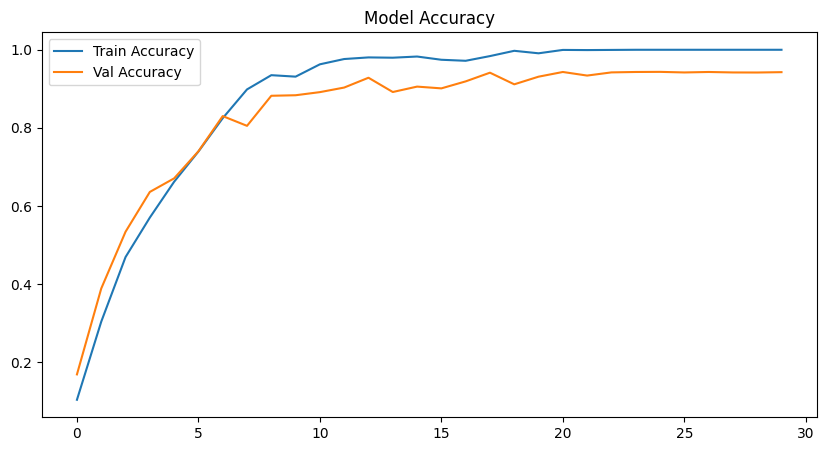

In [34]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

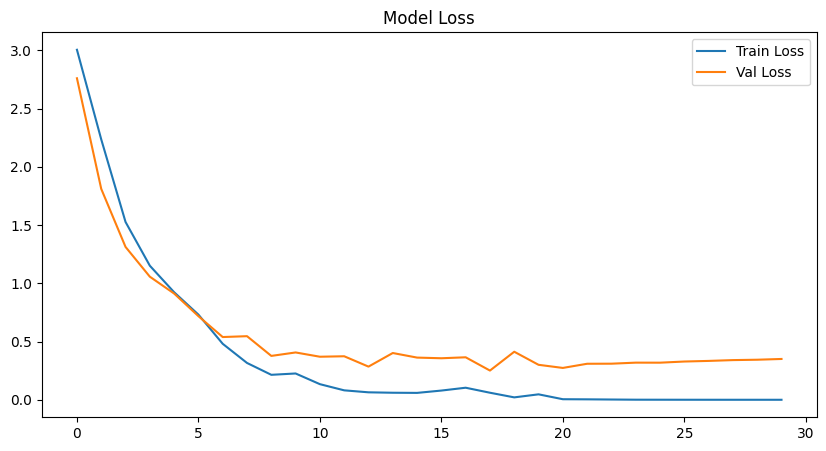

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### Model Evaluation

In [30]:
test_csv

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [31]:
# total classes
unique_class_ids = test_csv['ClassId'].unique()
print("Unique ClassIds:", unique_class_ids)
print("Total Unique ClassIds:", len(unique_class_ids))

Unique ClassIds: [16  1 38 33 11 18 12 25 35  7 23  4  9 21 20 27  3 13 10  5 17 34  2  8
 30 24 15 26 28 22 14 32 29  6 36 40 41 31 19  0 39 42 37]
Total Unique ClassIds: 43


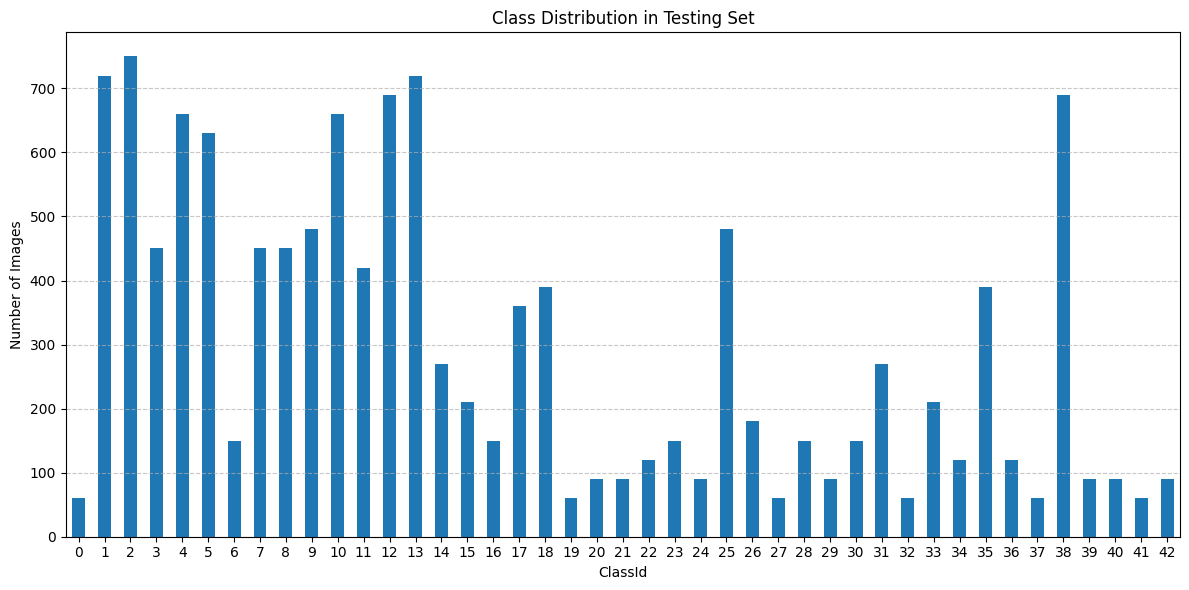

In [38]:
# Count the number of images per class
class_counts = test_csv['ClassId'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution in Testing Set")
plt.xlabel("ClassId")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
# the distribution of images across different classes in the training set
class_distribution = test_csv['ClassId'].value_counts()

# It prints the distribution
print("Class distribution in the training set:")
print(class_distribution)

Class distribution in the training set:
ClassId
2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: count, dtype: int64


In [16]:
# List of ClassIds with fewer images
classes_to_drop = [30, 16, 6, 34, 22, 36, 40, 20, 21, 39, 29, 24, 32, 27, 41, 42, 37, 0, 19]

# Drop these classes from the dataset, keeps only the rows where 'ClassId' is not in the list
filtered_test_csv = test_csv[~test_csv['ClassId'].isin(classes_to_drop)]  

print("Filtered dataset size:", len(filtered_test_csv))

Filtered dataset size: 10830


In [33]:
# Check the distribution of ClassId after filtering
class_counts_after_filtering = filtered_test_csv['ClassId'].value_counts()

# Print the class distribution
print("Class distribution after filtering:")
print(class_counts_after_filtering)

Class distribution after filtering:
ClassId
2     750
1     720
13    720
12    690
38    690
10    660
4     660
5     630
9     480
25    480
8     450
3     450
7     450
11    420
35    390
18    390
17    360
14    270
31    270
33    210
15    210
26    180
23    150
28    150
Name: count, dtype: int64


In [17]:
X_test_final, y_test_final = [], []

for i, row in filtered_test_csv.iterrows():
    img_path = os.path.join(data_dir, row['Path'])
    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32))
    X_test_final.append(image)
    y_test_final.append(row['ClassId'])

In [18]:
X_test_final = np.array(X_test_final) / 255.0  # Normalize images
X_test_final.shape         # shape is only possible after converting into the numpy array. 

(10830, 32, 32, 3)

In [19]:
import numpy as np

# Convert y to a NumPy array if not already
y_test_final= np.array(y_test_final)

# Get the number of unique classes
num_classes = len(np.unique(y_test_final))

print("Number of unique classes:", num_classes)

Number of unique classes: 24


In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels (y)
y_test_final = label_encoder.fit_transform(y_test_final)

# Check the unique encoded labels
print("Encoded labels:", np.unique(y_test_final))

Encoded labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [21]:
# Now you can apply one-hot encoding
from tensorflow.keras.utils import to_categorical
y_test_final = to_categorical(y_test_final)

# Check the shape of the one-hot encoded labels
print("One-hot encoded y shape:", y_test_final.shape)

One-hot encoded y shape: (10830, 24)


**Evaluation on Test CSV**

In [47]:
test_loss, test_acc = model.evaluate(X_test_final, y_test_final)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)

339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8706 - loss: 0.9577
Final Test Accuracy: 0.8729455471038818
Final Test Loss: 0.9252437353134155


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_final, axis=1)

339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


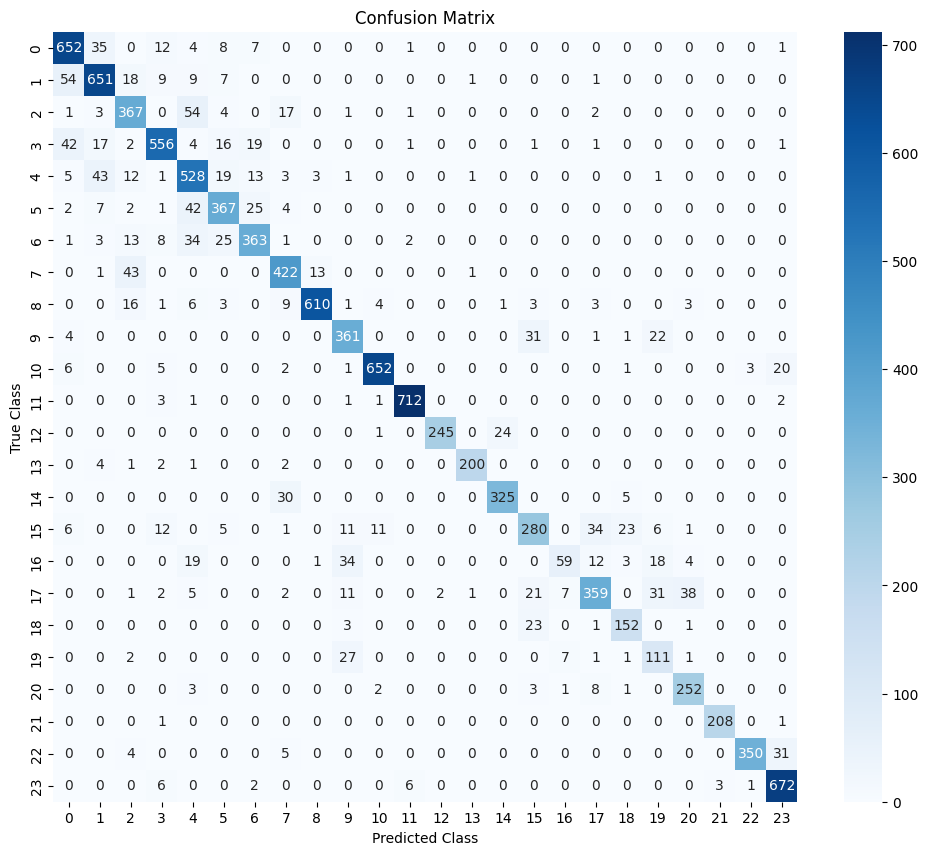

In [49]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [50]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       720
           1       0.85      0.87      0.86       750
           2       0.76      0.82      0.79       450
           3       0.90      0.84      0.87       660
           4       0.74      0.84      0.79       630
           5       0.81      0.82      0.81       450
           6       0.85      0.81      0.83       450
           7       0.85      0.88      0.86       480
           8       0.97      0.92      0.95       660
           9       0.80      0.86      0.83       420
          10       0.97      0.94      0.96       690
          11       0.98      0.99      0.99       720
          12       0.99      0.91      0.95       270
          13       0.98      0.95      0.97       210
          14       0.93      0.90      0.92       360
          15       0.77      0.72      0.74       390
          16       0.80      0.39      0.53       150
          17       0.85    

**Inference on sample images of Test.csv set**

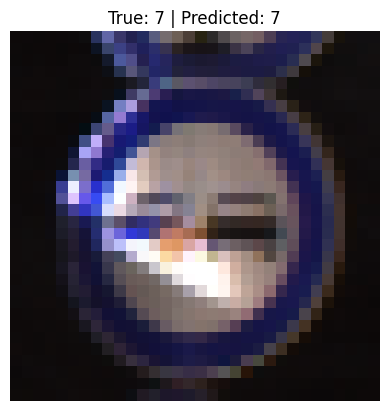

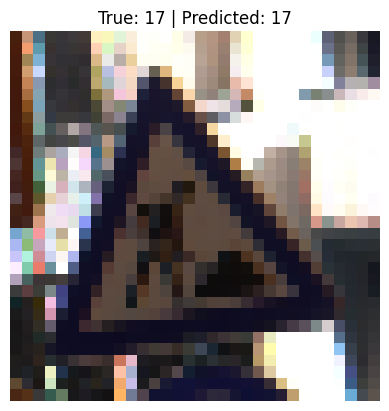

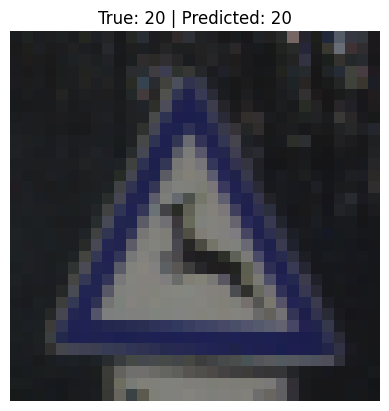

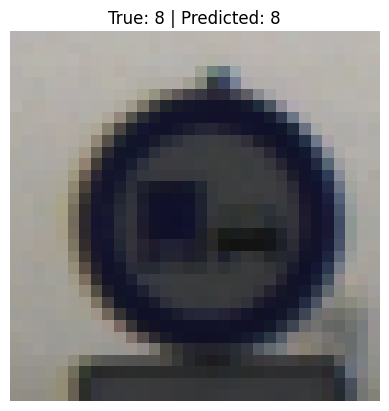

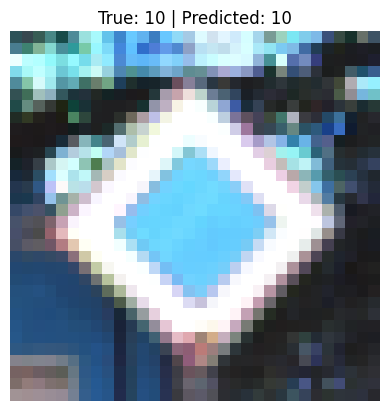

In [51]:
import matplotlib.pyplot as plt

# Pick a few random samples
indices = np.random.choice(len(X_test_final), 5)

for idx in indices:
    img = X_test_final[idx]
    true_label = y_true_classes[idx]
    pred_label = y_pred_classes[idx]
    
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

**Key Observations About Model Performance**

Overall accuracy is 83.4%, which is decent but shows room for improvement.

Imbalanced performance across classes:

Some classes like Class 2, 27, 40 show low precision/recall, meaning the model struggles with them.

Others like Class 10, 13, 14, 38 perform very well, with F1-scores near or above 0.90.

Low F1-scores in certain classes suggest overfitting or data imbalance.

Macro average F1-score (0.81) indicates inconsistent performance across all classes, while the weighted average is pulled up by well-represented classes.

## Design, Train , and Evaluate Deeper Architecture with Regularization Layer

**Dropout, L2, Batch Normalization, Early Stopping**

###  Model Architecture

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    # Fully Connected Layers with L2 Regularization
    Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(24, activation='softmax')
])


In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │              

 Total params: 1,508,792 (5.76 MB)

 Trainable params: 1,506,104 (5.75 MB)

 Non-trainable params: 2,688 (10.50 KB)

### Model Compilation

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #default learning rate is 0.001 for Adam

In [55]:
import time
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor
    patience=5,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

### Model Training

In [56]:
start_time = time.time()

history = model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping]
)

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 271ms/step - accuracy: 0.0438 - loss: 5.0823 - val_accuracy: 0.0560 - val_loss: 4.4677
Epoch 2/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.0664 - loss: 4.7164 - val_accuracy: 0.0560 - val_loss: 4.3954
Epoch 3/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.1003 - loss: 4.4416 - val_accuracy: 0.0675 - val_loss: 4.4020
Epoch 4/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.1731 - loss: 3.9838 - val_accuracy: 0.1400 - val_loss: 4.0697
Epoch 5/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.2573 - loss: 3.5435 - val_accuracy: 0.2223 - val_loss: 3.6864
Epoch 6/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.3037 - loss: 3.2010 - val_accuracy: 0.3148 - val_loss: 3.1900
Epoch 7/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.3668 - loss: 2.9170 - val_accuracy: 0.4093 - val_loss: 2.6265
Epoch 8/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - accuracy: 0.3972 - loss: 2.6117 - val_accu

In [68]:
# assuming you’ve already done:
train_accuracies = history.history['accuracy']
val_accuracies   = history.history['val_accuracy']

# final training accuracy
print(f"Final training accuracy:   {train_accuracies[-1]*100:.2f}%")

# final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Final training accuracy:   94.10%
Final validation accuracy: 97.89%


Text(0.5, 1.0, 'Model Accuracy')

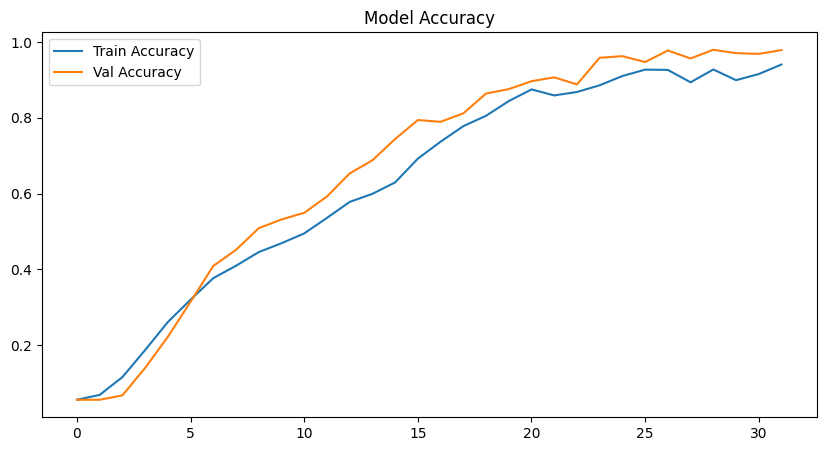

In [58]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

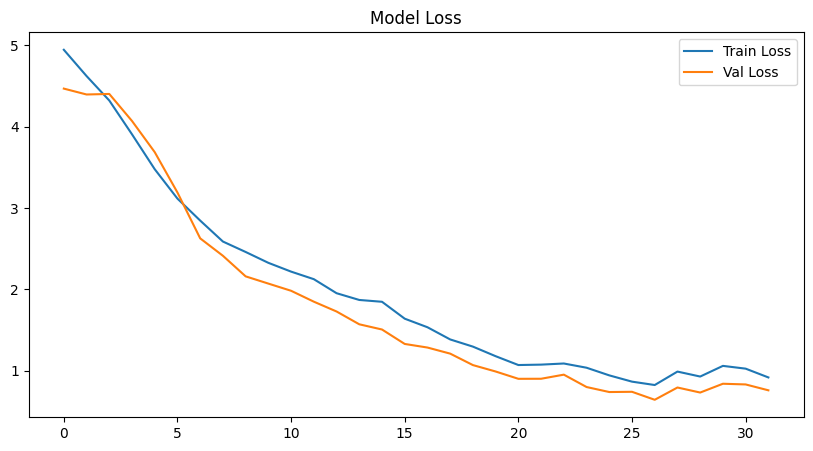

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### Model Evaluation

In [60]:
# Evaluate on Test.csv test set.
test_loss, test_acc = model.evaluate(X_test_final, y_test_final)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)

339/339 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9572 - loss: 0.7106
Final Test Accuracy: 0.9557710289955139
Final Test Loss: 0.7131592631340027


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_final, axis=1)

339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step


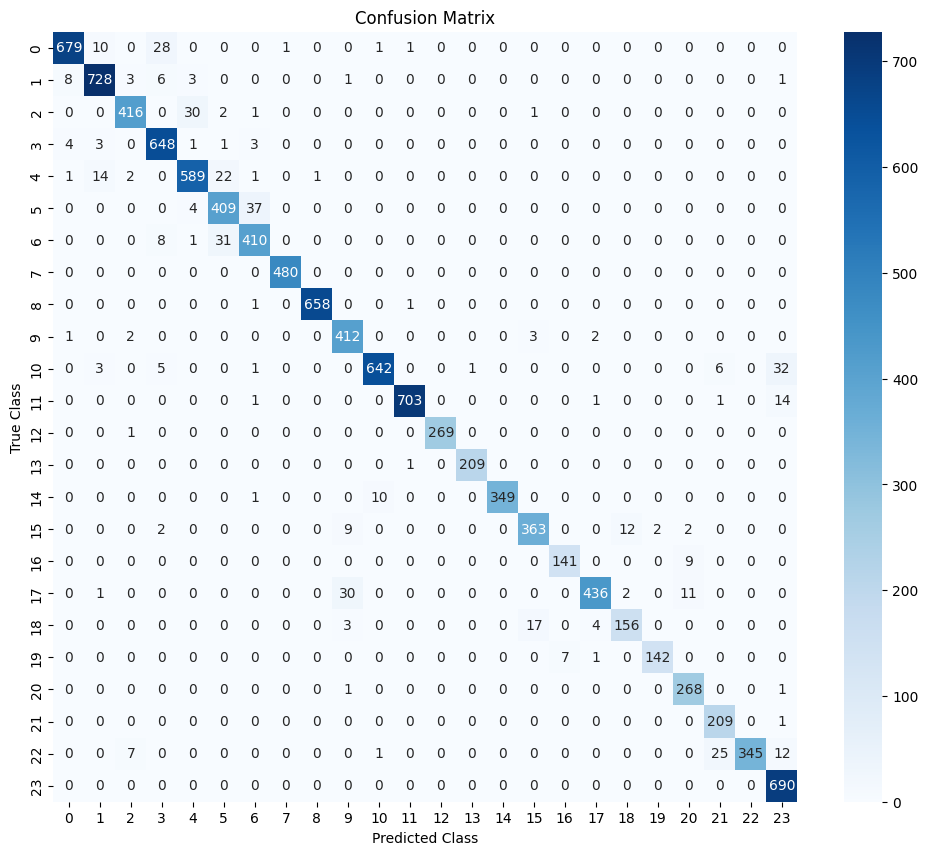

In [62]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [63]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       720
           1       0.96      0.97      0.96       750
           2       0.97      0.92      0.94       450
           3       0.93      0.98      0.96       660
           4       0.94      0.93      0.94       630
           5       0.88      0.91      0.89       450
           6       0.90      0.91      0.91       450
           7       1.00      1.00      1.00       480
           8       1.00      1.00      1.00       660
           9       0.90      0.98      0.94       420
          10       0.98      0.93      0.96       690
          11       1.00      0.98      0.99       720
          12       1.00      1.00      1.00       270
          13       1.00      1.00      1.00       210
          14       1.00      0.97      0.98       360
          15       0.95      0.93      0.94       390
          16       0.95      0.94      0.95       150
          17       0.98    

Train Accuracy: 96.47% — The model is learning well on the training data.

Validation Accuracy: 99.62% — Excellent performance on validation data, suggesting the model generalizes well.

Test Accuracy: 96.84% — Very good accuracy on unseen data (test set).

Overall Accuracy: 97% — Excellent performance on the test set.

Macro Average: Precision, recall, and F1 score around 0.94-0.95, indicating balanced performance across classes.

Weighted Average: Precision, recall, and F1 score around 0.97, reflecting the model's strong performance on more frequent classes.

Most classes have very high precision and recall, but some classes (like class 21 and 27) show lower scores, particularly in recall (e.g., 0.67 and 0.50), indicating that these classes might be harder for the model to predict accurately.

**Inference on sample images of Test.csv set**

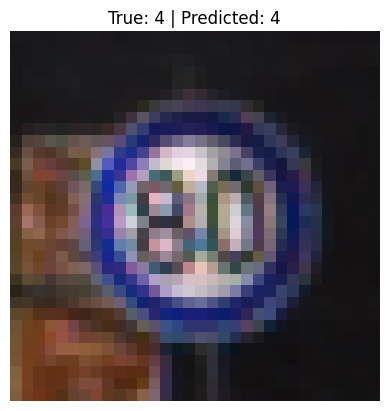

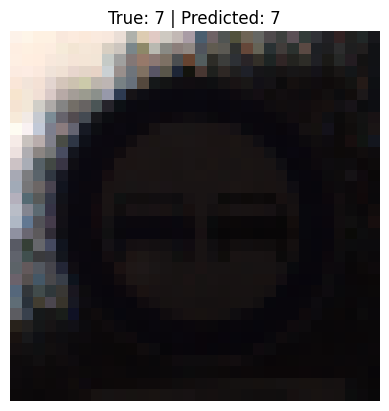

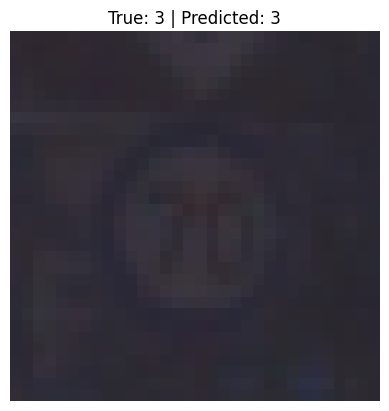

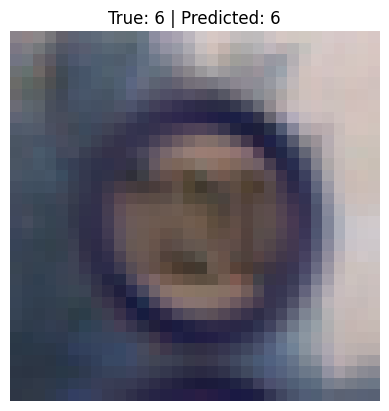

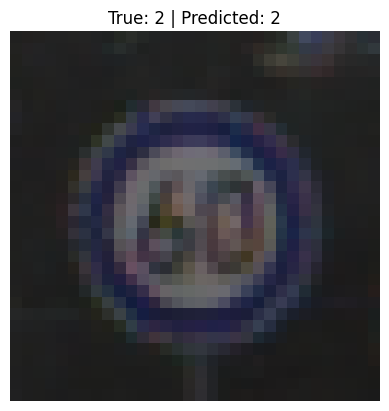

In [64]:
import matplotlib.pyplot as plt

# Pick a few random samples
indices = np.random.choice(len(X_test_final), 5)

for idx in indices:
    img = X_test_final[idx]
    true_label = y_true_classes[idx]
    pred_label = y_pred_classes[idx]
    
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

## Experimentation and Comparative Analysis

### Baseline vs. Deeper Model Performance

**Classification Accuracy:**

Baseline Model: Accuracy of 83% on the test set.

Deeper Model: Accuracy of 97% on the test set.

Conclusion: The deeper model significantly outperforms the baseline in terms of classification accuracy, showing a clear improvement with more layers and filters.

**Loss:**

Baseline Model: The loss is higher, indicating the model struggled to minimize errors.

Deeper Model: The loss is considerably lower, suggesting better optimization and learning from the data.

Conclusion: The decrease in loss further confirms the deeper model's improved performance.

**Evaluation Metrics (Precision, Recall, F1-Score):**

Baseline Model: Precision, recall, and F1-score values are lower, especially for underrepresented classes.

Deeper Model: These metrics are much higher across most classes, with many achieving near-perfect values (1.00).

Conclusion: The deeper model provides better class-wise performance and generalizes better across all classes.

**Discussion:**

Adding More Layers and Filters: The increase in model complexity with additional layers and filters improves performance. More layers allow the model to learn richer features, and additional filters help capture more detailed patterns in the data.

Overall Improvement: The deeper architecture, coupled with the use of regularization (like dropout and L2 regularization), leads to better accuracy, lower loss, and higher precision, recall, and F1-scores compared to the baseline.

### Computational Efficiency

**Training Time & Computational Cost:**

Baseline Model:

Fewer layers & filters → Faster training (less computational cost).

Lower memory usage and quicker epochs.

Deeper Model:

More layers & filters → Longer training time.

Higher GPU/CPU usage, more parameters, and increased memory consumption.

**Trade-offs:**

Model Complexity:

Improves accuracy and generalization (as seen in the deeper model).

But it increases training time, requires more hardware resources, and can risk overfitting without regularization.

Efficiency:

Simpler models are faster and more efficient but often less accurate.

Ideal for real-time or resource-constrained environments.

### Optimizer Analysis SGD vs Adam

The model has been already trained using the Adam optimizer on building the model architecture with dropout and L2 regularization making a bit difference fromm the base model, so this is for the SGD optimizer, so that we can analysis and take the comparision of these two optimizer. 

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    # Fully Connected Layers with L2 Regularization

    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Dense(24, activation='softmax')
])


In [23]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,  # try 0.05–0.1
    decay_steps=84,             # 1 epoch
    decay_rate=0.9
)

optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
import time
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor
    patience=5,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)


start_time = time.time()

history = model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.0929 - loss: 4.0041 - val_accuracy: 0.1133 - val_loss: 3.6921
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 0.2673 - loss: 3.1626 - val_accuracy: 0.1295 - val_loss: 3.4062
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.4773 - loss: 2.3134 - val_accuracy: 0.5444 - val_loss: 2.2252
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.6142 - loss: 1.8627 - val_accuracy: 0.7369 - val_loss: 1.5826
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.7379 - loss: 1.4490 - val_accuracy: 0.6972 - val_loss: 1.6287
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.7895 - loss: 1.3236 - val_accuracy: 0.8926 - val_loss: 1.1055
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.8440 - loss: 1.1405 - val_accuracy: 0.9177 - val_loss: 0.9647
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.8699 - loss: 1.0652 - 

In [28]:
# assuming you’ve already done:
train_accuracies = history.history['accuracy']
val_accuracies   = history.history['val_accuracy']

# final training accuracy
print(f"Final training accuracy:   {train_accuracies[-1]*100:.2f}%")

# final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Final training accuracy:   97.18%
Final validation accuracy: 98.04%


In [39]:
test_loss, test_acc = model.evaluate(X_test_final, y_test_final)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)

339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9602 - loss: 0.6866
Final Test Accuracy: 0.9590027928352356
Final Test Loss: 0.686342179775238


Text(0.5, 1.0, 'Model Accuracy')

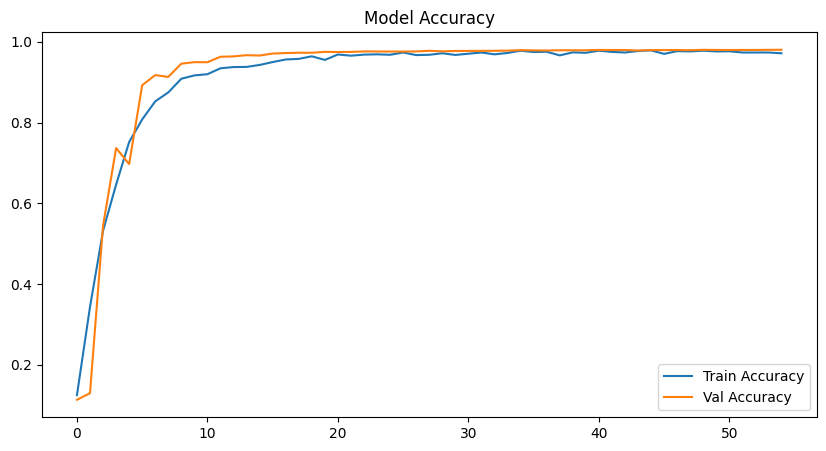

In [40]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

**SGD:**

Final Training Accuracy: ~97.18%

Final Validation Accuracy: ~98.08%

Training Time: ~938.97 seconds

**Adam:** 

Final Training Accuracy: ~94.10%

Final Validation Accuracy: ~97.89%

Training Time: 823.62 seconds

Adam converged faster and reached high accuracy.

SGD was slower as compared to the Adam.

Conclusion: Adam is better for faster convergence and higher performance, especially for deep models.

### Challenges and Observations

**Difficulties faced**
- Since the the size of the data is decreased to 2600 and there is being training the model in batch wise, and if i mistakenly keep the wrong parameter, then it needs to run the model again, so its type of repitative task. since the SGD model was too slow for the convergence, there need to find the best parameter and layers, it was a little bit chanllengeing part of model training, otherwise the deep model with adam was trained with default hyperparameter. 

**Overfitting and underfitting**
- So far the model building wiht the regularization layer is giving good performance avoiding the overfitting problem. The validation accuracy is going higher than the training set accuracy, that means the model is performing more better in unseen data. in this way, the validation set is monitoring about the overfitting of model performance during the time of training. 

**Total training time for deeper architecture**
- In the deeper architecture, after implementing the SGD optimizer with the default learning rate, the total time taken for training was about 2022.586019039154 seconds but there were not any convergence. After optimization the training Time: 823.62 seconds and Training Time: ~938.97 seoncds.

# Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)

**Preparing Dataset images for 224 by 224 pixel size.**

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
import tensorflow as tf

# List all physical devices
devices = tf.config.list_physical_devices()
for device in devices:
    print(f"{device.device_type} - {device.name}")

CPU - /physical_device:CPU:0
GPU - /physical_device:GPU:0
GPU - /physical_device:GPU:1


### Training and Validation Set with 24 classes

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# List of the 24 classes you want to work with
wanted_classes = ['1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '17', '18', '23', '25', '26', '28', '33', '35', '38', '43']

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/gtsrb-german-traffic-sign/Train',
    target_size=(224, 224),  # Resize images for the model
    batch_size=128,
    class_mode='categorical',
    subset='training',
    classes=wanted_classes  # Only use these classes
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/gtsrb-german-traffic-sign/Train',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    classes=wanted_classes  # Only use these classes
)

Found 25968 images belonging to 24 classes.
Found 6491 images belonging to 24 classes.


In [8]:
# Get the total number of samples in the train and validation generators
train_samples = train_generator.samples
val_samples = val_generator.samples

# Print the results
print(f'Total training samples: {train_samples}')
print(f'Total validation samples: {val_samples}')

Total training samples: 25968
Total validation samples: 6491


## Loading and Adapting a Pre - Trained Model ( VGG16 )

In [9]:
# Load VGG16 model without the top classification layer (include_top=False)
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

I0000 00:00:1746723245.868563      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746723245.868801      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Feature Extraction - Classification layers

In [10]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(24, activation='softmax')(x)  # Output layer with softmax for classification


In [11]:
# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 15,264,600 (58.23 MB)

 Trainable params: 549,912 (2.10 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Model Training 

In [12]:
import time

# Record the start time
start_time = time.time()
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs based on your needs
    validation_data=val_generator,
    verbose=1
)
# Record the end time
end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Epoch 1/10


I0000 00:00:1746723271.828979     115 service.cc:148] XLA service 0x7fad5440fa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746723271.830159     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746723271.830179     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746723272.224779     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-08 16:54:40.044704: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earlies

111/203 ━━━━━━━━━━━━━━━━━━━━ 1:03 688ms/step - accuracy: 0.1476 - loss: 2.8820

2025-05-08 16:56:26.478436: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[112,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[112,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-08 16:56:26.536568: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.058224778s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[112,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[112,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

203/203 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.1861 - loss: 2.7281 - val_accuracy: 0.3899 - val_loss: 2.0578
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 143s 693ms/step - accuracy: 0.3616 - loss: 2.0565 - val_accuracy: 0.3915 - val_loss: 1.9226
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 143s 693ms/step - accuracy: 0.3947 - loss: 1.9244 - val_accuracy: 0.4676 - val_loss: 1.8012
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 144s 697ms/step - accuracy: 0.4317 - loss: 1.8145 - val_accuracy: 0.4996 - val_loss: 1.7075
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 143s 692ms/step - accuracy: 0.4475 - loss: 1.7578 - val_accuracy: 0.4636 - val_loss: 1.7063
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 144s 697ms/step - accuracy: 0.4581 - loss: 1.7077 - val_accuracy: 0.4767 - val_loss: 1.7039
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 147s 712ms/step - accuracy: 0.4724 - loss: 1.6667 - val_accuracy: 0.4985 - val_loss: 1.6430
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 143s 693ms/step - accuracy: 0.4806 - loss: 1.6478 

In [13]:
# assuming you’ve already done:
train_accuracies = history.history['accuracy']
val_accuracies   = history.history['val_accuracy']

# final training accuracy
print(f"Final training accuracy:   {train_accuracies[-1]*100:.2f}%")

# final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Final training accuracy:   49.08%
Final validation accuracy: 49.44%


Text(0.5, 1.0, 'Model Accuracy')

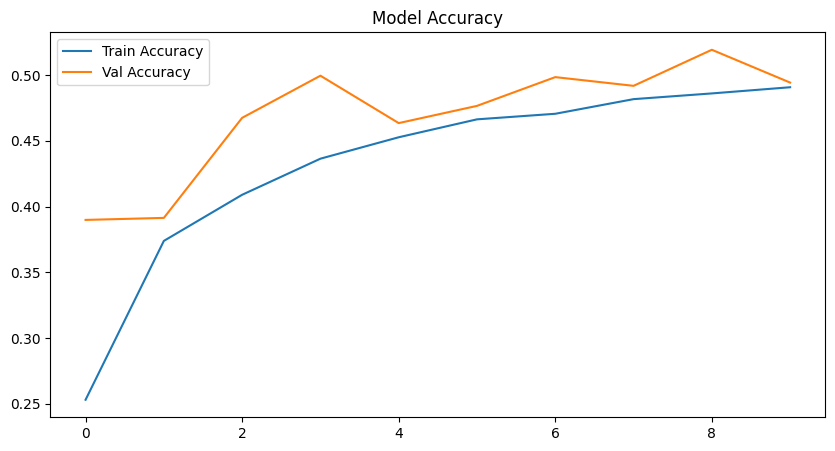

In [14]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

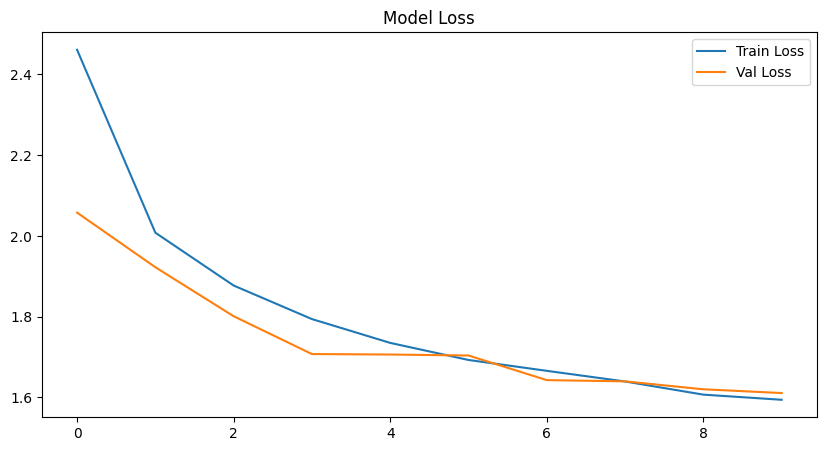

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### Fine Tuning

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Unfreeze the top layers of VGG16 (keeping earlier layers frozen)
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 convolutional blocks
    layer.trainable = True

# Recompile the model (important after changing trainable layers)
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use a small learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model again with fine-tuning
history_finetuned = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs based on your needs
    validation_data=val_generator,
    verbose=1
)


Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 172s 787ms/step - accuracy: 0.5892 - loss: 1.2699 - val_accuracy: 0.6971 - val_loss: 0.9671
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 163s 793ms/step - accuracy: 0.7487 - loss: 0.7679 - val_accuracy: 0.7668 - val_loss: 0.7259
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 159s 775ms/step - accuracy: 0.8130 - loss: 0.5616 - val_accuracy: 0.8136 - val_loss: 0.6110
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 163s 793ms/step - accuracy: 0.8542 - loss: 0.4449 - val_accuracy: 0.8372 - val_loss: 0.5380
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 161s 779ms/step - accuracy: 0.8892 - loss: 0.3481 - val_accuracy: 0.8530 - val_loss: 0.4772
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 158s 769ms/step - accuracy: 0.9068 - loss: 0.2988 - val_accuracy: 0.8638 - val_loss: 0.4388
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 161s 781ms/step - accuracy: 0.9239 - loss: 0.2395 - val_accuracy: 0.8663 - val_loss: 0.4228
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 164s 798ms/step - accuracy: 0.9309 -

In [24]:
# assuming you’ve already done:
train_accuracies = history_finetuned.history['accuracy']
val_accuracies   = history_finetuned.history['val_accuracy']

# final training accuracy
print(f"Final training accuracy:   {train_accuracies[-1]*100:.2f}%")

# final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Final training accuracy:   94.89%
Final validation accuracy: 89.17%


Text(0.5, 1.0, 'Model Accuracy')

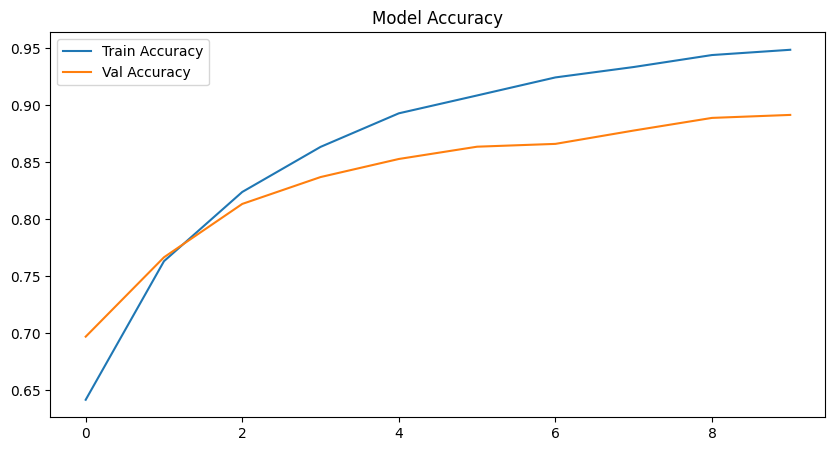

In [21]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_finetuned.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetuned.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

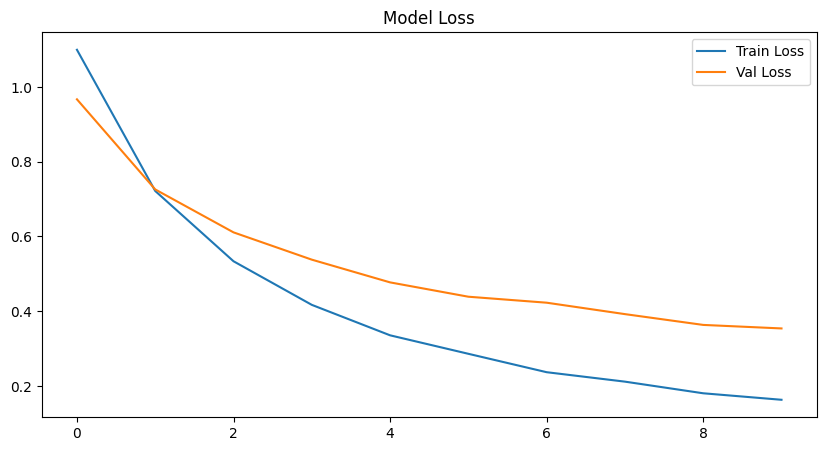

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history_finetuned.history['loss'], label='Train Loss')
plt.plot(history_finetuned.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### Loading Test Set

In [57]:
test_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

# Fix the paths by adding the full prefix
base_path = '/kaggle/input/gtsrb-german-traffic-sign'
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(base_path, x))

In [58]:
print(test_df['Path'].head())
print(os.path.exists(test_df['Path'].iloc[0]))  # Should print True

0    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
1    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
2    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
3    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
4    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
Name: Path, dtype: object
True


In [59]:
test_df['ClassId'] = test_df['ClassId'].astype(str)  # Convert ClassId to strings

In [60]:
# List of 24 classes you want to work with (make sure they are strings)
wanted_classes = ['1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '17', '18', '23', '25', '26', '28', '33', '35', '38', '43']

In [62]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False,
    classes=wanted_classes
)

Found 10560 validated image filenames belonging to 24 classes.


### Testing / Evaluating on Test set

In [63]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, verbose=1)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9071 - loss: 0.2946 
Test Loss: 0.30747321248054504
Test Accuracy: 0.9056817889213562


### Prediction on random images from test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


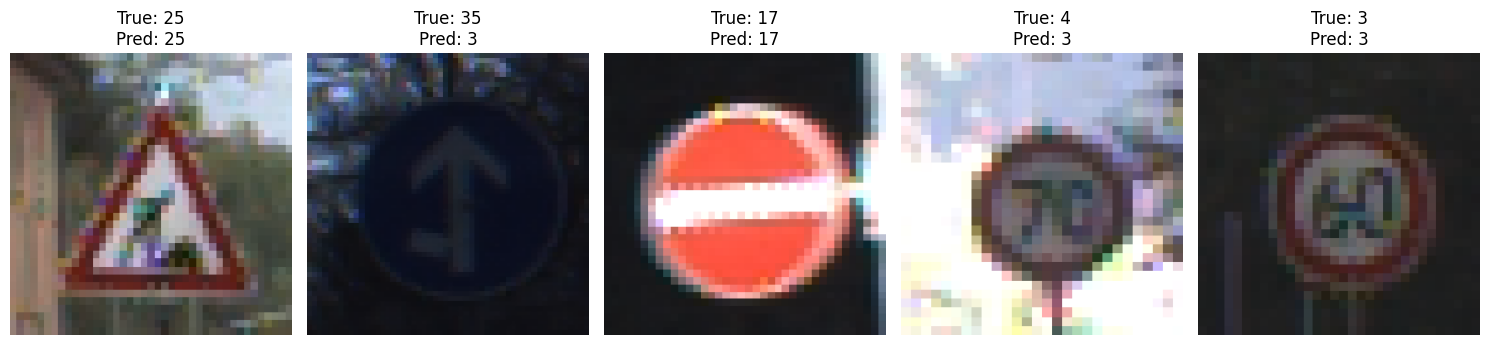

In [69]:
# Load Test.csv with true labels
test_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

# Add full path to images
test_df['full_path'] = test_df['Path'].apply(lambda x: os.path.join('/kaggle/input/gtsrb-german-traffic-sign', x))

# Randomly pick 5 rows
sample_df = test_df.sample(n=5).reset_index(drop=True)

# Map prediction index to actual class label
label_map = {i: cls for i, cls in enumerate(wanted_classes)}

# Plot predictions
plt.figure(figsize=(15, 8))
for i in range(5):
    img_path = sample_df.loc[i, 'full_path']
    true_label = sample_df.loc[i, 'ClassId']

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    predicted_label = label_map[pred_class]

    # Show image with true vs predicted
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()

### Clasification report:- Confusion matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 624ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       720
           1       0.93      0.84      0.88       750
           2       0.68      0.70      0.69       450
           3       0.91      0.92      0.91       660
           4       0.79      0.90      0.84       630
           5       0.90      0.77      0.83       450
           6       0.78      0.78      0.78       450
           7       0.97      0.85      0.91       480
           8       0.93      1.00      0.96       660
           9       0.91      0.95      0.93       420
          10       0.98      1.00      0.99       690
          11       0.99      0.99      0.99       720
          12       0.99      0.99      0.99       270
          13       1.00      0.99      1.00       210
          14       0.99      0.99      0.99       360
          15       0.93      0.90      0.91       390
          16   

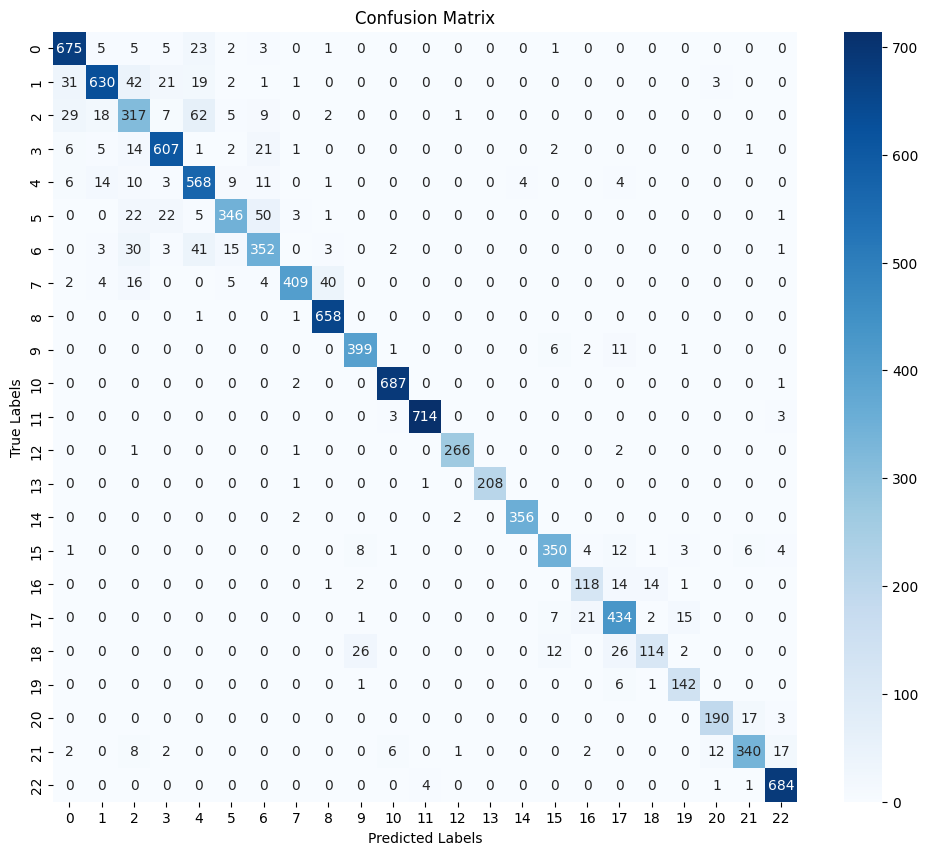

In [64]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities
pred_probs = model.predict(test_generator)
# Get predicted class indices
y_pred = np.argmax(pred_probs, axis=1)

# Get true class labels
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**compare results with the baseline and deeper models from Part A**

**Discuss whether transfer learning outperforms training from scratch for your dataset**